## reading

In [1]:
import numpy as np
import sklearn.preprocessing 

data = np.genfromtxt("wall-robot-navigation.csv", dtype=None, delimiter=',', names=True)
print(data.dtype.names)

class_field = data.dtype.names.index('Class')

values = np.array([np.array(i.tolist())[:-1] for i in data])
answers = np.array([i[class_field] for i in data], dtype=int)
class_amount = len(set(answers))
features_amount = len(values[0])

scaler = sklearn.preprocessing.MinMaxScaler().fit(values)
values = scaler.transform(values)

print('dataset size: {}'.format(len(values)))
print('class amount: {}'.format(class_amount))
print('features amount: {}'.format(features_amount))

('V1', 'V2', 'V3', 'V4', 'Class')
dataset size: 5456
class amount: 4
features amount: 4


## metric and kernel functions

In [2]:
from math import e, pi, hypot, cos

def in_range_one(variable, value):
    return value if abs(variable) < 1 else 0

kernel_functions = {
    "uniform":      (lambda u: in_range_one(u, 0.5)),
    "triangular":   (lambda u: in_range_one(u, 1 - abs(u))),
    "epanechnikov": (lambda u: in_range_one(u, 0.75 * (1 - u ** 2))),
    "quartic":      (lambda u: in_range_one(u, (15 / 16) * (1 - u ** 2) ** 2)),
    "triweight":    (lambda u: in_range_one(u, (35 / 32) * (1 - u ** 2) ** 3)),
    "tricube":      (lambda u: in_range_one(u, (70 / 81) * (1 - abs(u) ** 3) ** 3)),
    "gaussian":     (lambda u: (1 / (2 * pi) ** (0.5)) * e ** (-0.5 * u ** 2)),
    "cosine":       (lambda u: in_range_one(u, (pi / 4) * cos(pi * u / 2))),
    "logistic":     (lambda u: 1 / (e ** u + 2 + e ** (-u))),
    "sigmoid":      (lambda u: 2 / (pi * (e ** u + e ** (-u))))
}

distance_functions = ["manhattan", "euclidean", "chebyshev"]

## score computation

In [3]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score

# using values and answers
def score(k, distance, kernel, avrg="weighted", variable=True):
    pred = [0] * len(values)
    
    if variable:
        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto', n_jobs=4, metric=distance)
        nbrs.fit(values)
        distances, indices = nbrs.kneighbors(values)
    else:
        nbrs = NearestNeighbors(radius=k, algorithm='auto', n_jobs=4, metric=distance)
        nbrs.fit(values)
        distances, indices = nbrs.radius_neighbors(values)   

    for i in range(len(values)):
        window = distances[i][-1] if variable else k
        classes = [0] * class_amount
        for j in range(1, len(distances[i])):
            classes[answers[indices[i][j]] - 1] += kernel(distances[i][j] / 
                                                          (1 if window == 0 else window))
        pred[i] = max(zip(classes, range(len(classes))))[1] + 1

    return f1_score(answers, pred, average=avrg)

In [4]:
from time import time
import warnings

warnings.filterwarnings('ignore')
start = time()

maximum, best = 0, (0, '', '')
results = []

for k in range(1, 9):
    for name in distance_functions:
        res = dict(map(lambda x: (x, score(k, name, kernel_functions[x])), kernel_functions))
        results.append((k, name, res))

for k, dist, r in results:
    for kr in r:
        maximum, best = max((maximum, best), (r[kr], (k, dist, kr)))
    
print(maximum, best)
took = time() - start
print('it took {}:{}'.format(int(took) // 60, int(took % 60)))

0.9747035124852561 (4, 'manhattan', 'cosine')
it took 5:49


## showing dependencies

In [5]:
import matplotlib.pyplot as plt

def show_plot(title, xlabel, ylabel, results, axes=[0, 0, 1, 1], yrange=[0.9, 1.]):
    new_results = {}
    for i in results:
        new_results["{}\n{:.05f}".format(i, results[i])] = results[i]

    results = new_results

    ax = plt.figure().add_axes(axes)
    ax.set_ylim(yrange)
    plt.bar(range(len(results)), list(results.values()), align='center')
    plt.xticks(range(len(results)), list(results.keys()))

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()

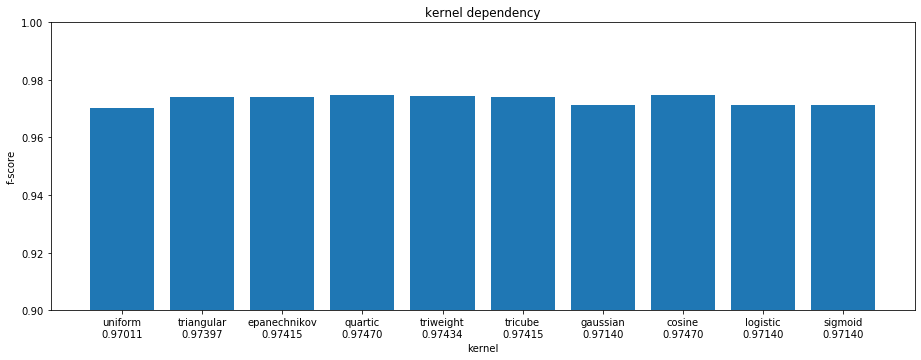

In [6]:
show_plot('kernel dependency', 'kernel', 'f-score', 
          dict(map(lambda x: (x, score(best[0], best[1], kernel_functions[x])), kernel_functions)),
          [0, 0.6, 2, 1])

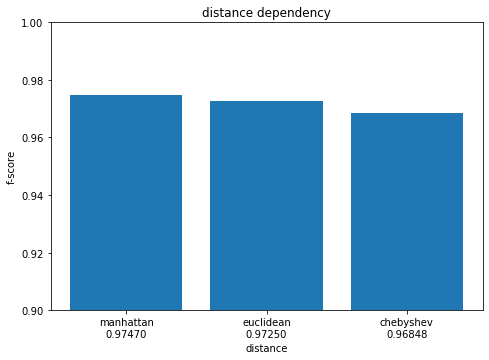

In [7]:
show_plot('distance dependency', 'distance', 'f-score',
          dict(map(lambda x: (x, score(best[0], x, kernel_functions[best[2]])), distance_functions)))

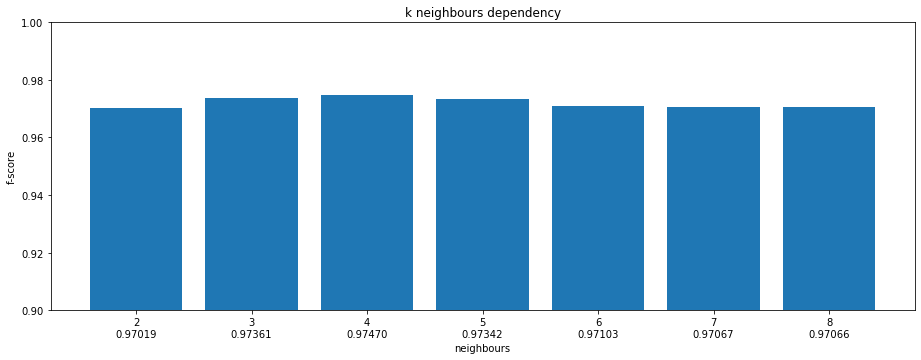

In [8]:
show_plot('k neighbours dependency', 'neighbours', 'f-score',
         dict(map(lambda x: (x, score(x, best[1], kernel_functions[best[2]])), [i for i in range(2, 9)])), 
         [0, 0.6, 2, 1])

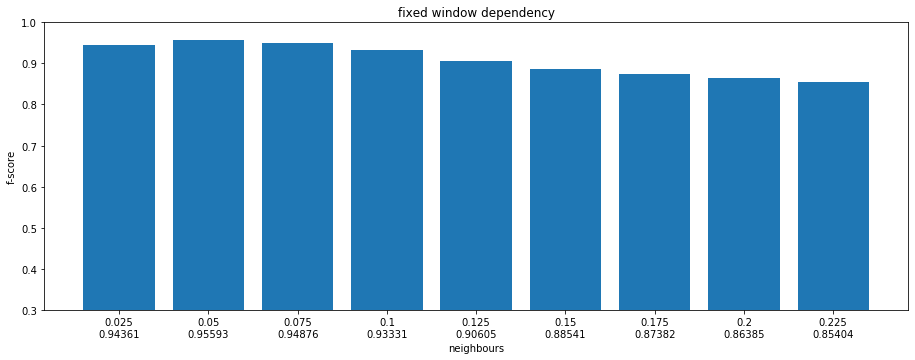

In [9]:
show_plot('fixed window dependency', 'neighbours', 'f-score',
         dict(map(lambda x: (x, score(x, best[1], kernel_functions[best[2]], variable=False)), 
                  [i / 40 for i in range(1, 10, 1)])), 
         axes=[0, 0.6, 2, 1],
         yrange=[0.3, 1.])